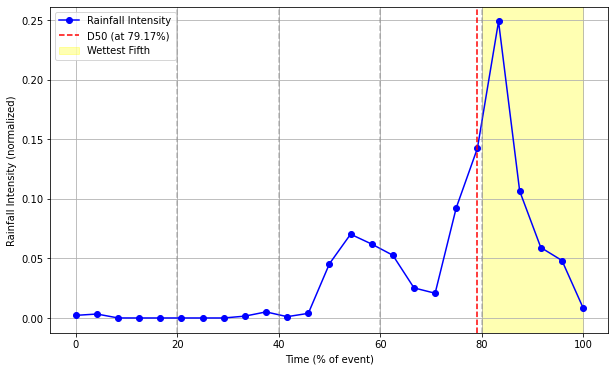

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Given rainfall data
rainfall_data = [0.04758898541331291, 0.0721057653427124, 0.0003166475798934698, 9.062059689313173e-07,
                 6.768620437469508e-07, 3.3831730661404436e-07, 1.7378408756485442e-07, 1.0045905582956038e-06,
                 0.033553626388311386, 0.11095544695854187, 0.02400837279856205, 0.08434712886810303,
                 0.9903910160064697, 1.5300896167755127, 1.3496136665344238, 1.1452085971832275,
                 0.5489916205406189, 0.45185941457748413, 2.013714551925659, 3.0990607738494873,
                 5.415703773498535, 2.3180184364318848, 1.286536455154419, 1.0497450828552246, 
                 0.18542736768722534]

# Generate a time axis (normalized between 0% and 100%)
n_points = len(rainfall_data)
time = np.linspace(0, 100, n_points)

# Normalize the rainfall data so that the total rainfall sums to 1
rainfall_data = np.array(rainfall_data)
rainfall_data /= np.sum(rainfall_data)

# Function to compute D50 (time at which 50% of rainfall has occurred)
def compute_d50(time, rainfall_intensity):
    cumulative_rainfall = np.cumsum(rainfall_intensity)  # Compute cumulative rainfall
    
    # Find the index where cumulative rainfall exceeds 50%
    d50_idx = np.argmax(cumulative_rainfall >= 0.5)
    
    # Return the corresponding time at D50
    return time[d50_idx]

# Function to find the wettest fifth (quintile) in terms of total rainfall
def find_wettest_fifth(rainfall_intensity):
    # Split the rainfall into five equal parts
    n_points = len(rainfall_intensity)
    fifth_size = n_points // 5
    
    # Calculate the total rainfall in each fifth
    rainfall_in_fifths = [
        np.sum(rainfall_intensity[i * fifth_size:(i + 1) * fifth_size])
        for i in range(5)
    ]
    
    # Find the index of the wettest fifth
    wettest_fifth_idx = np.argmax(rainfall_in_fifths)
    
    # Return the start and end times of the wettest fifth
    start_time = wettest_fifth_idx * 20  # Each fifth corresponds to 20% of the time
    end_time = start_time + 20  # 20% block
    
    return start_time, end_time

# Compute D50
d50_time = compute_d50(time, rainfall_data)

# Find the wettest fifth
wettest_start, wettest_end = find_wettest_fifth(rainfall_data)

# Plot the rainfall event
plt.figure(figsize=(10, 6))
plt.plot(time, rainfall_data, label='Rainfall Intensity', color='blue', marker='o')
plt.axvline(d50_time, color='red', linestyle='--', label=f'D50 (at {d50_time:.2f}%)')

# Shade the wettest fifth
plt.axvspan(wettest_start, wettest_end, color='yellow', alpha=0.3, label='Wettest Fifth')

# Add vertical lines to mark the boundaries of the fifths
for i in range(1, 5):
    plt.axvline(i * 20, color='gray', linestyle='--', alpha=0.5)

# Add labels and title
plt.xlabel('Time (% of event)')
plt.ylabel('Rainfall Intensity (normalized)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


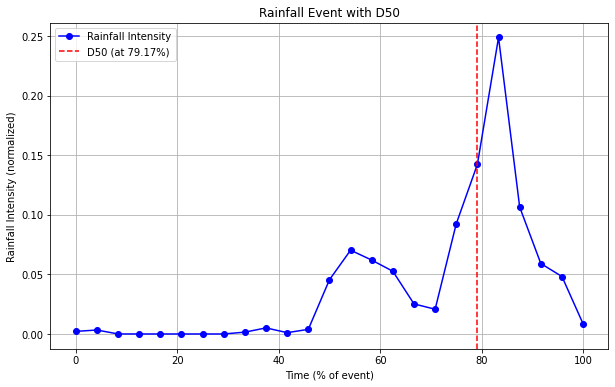

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Given rainfall data
rainfall_data = [0.04758898541331291, 0.0721057653427124, 0.0003166475798934698, 9.062059689313173e-07,
                 6.768620437469508e-07, 3.3831730661404436e-07, 1.7378408756485442e-07, 1.0045905582956038e-06,
                 0.033553626388311386, 0.11095544695854187, 0.02400837279856205, 0.08434712886810303,
                 0.9903910160064697, 1.5300896167755127, 1.3496136665344238, 1.1452085971832275,
                 0.5489916205406189, 0.45185941457748413, 2.013714551925659, 3.0990607738494873,
                 5.415703773498535, 2.3180184364318848, 1.286536455154419, 1.0497450828552246, 
                 0.18542736768722534]

# Generate a time axis (normalized between 0% and 100%)
n_points = len(rainfall_data)
time = np.linspace(0, 100, n_points)

# Normalize the rainfall data so that the total rainfall sums to 1
rainfall_data = np.array(rainfall_data)
rainfall_data /= np.sum(rainfall_data)

# Function to compute D50 (time at which 50% of rainfall has occurred)
def compute_d50(time, rainfall_intensity):
    cumulative_rainfall = np.cumsum(rainfall_intensity)  # Compute cumulative rainfall
    
    # Find the index where cumulative rainfall exceeds 50%
    d50_idx = np.argmax(cumulative_rainfall >= 0.5)
    
    # Return the corresponding time at D50
    return time[d50_idx]

# Compute D50
d50_time = compute_d50(time, rainfall_data)

# Plot the rainfall event
plt.figure(figsize=(10, 6))
plt.plot(time, rainfall_data, label='Rainfall Intensity', color='blue', marker='o')
plt.axvline(d50_time, color='red', linestyle='--', label=f'D50 (at {d50_time:.2f}%)')

# Add labels and title
plt.xlabel('Time (% of event)')
plt.ylabel('Rainfall Intensity (normalized)')
plt.title('Rainfall Event with D50')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import iris
import iris.coord_categorisation
import sys
import time
import datetime
from datetime import datetime
import matplotlib.pyplot as plt

sys.path.insert(1, '../Finding_AMAX_Events')
from Identify_Events_Functions import *
from New_Identify_Events_Functions import *
sys.path.insert(1, '../../ProcessEvents')
from Get_Events_Functions import *

home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

gauge_num=4
em = 'bb198'
yrs_range= '2060_2081'
sample_cube = iris.load(home_dir + f'datadir/UKCP18_every30mins/2.2km_bng/{yrs_range}/{em}/bng_{em}a.pr206101.nc')[0][1,:,:]
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

def remove_leading_and_trailing_zeroes(df, threshold = 0.1):
    
    # Identify the start and end of the event where values are above the threshold
    event_start = df[df['precipitation (mm/hr)'] >= threshold].index.min()
    event_end = df[df['precipitation (mm/hr)'] >= threshold].index.max()

    # Handle cases where no values are above the threshold
    if pd.isna(event_start) or pd.isna(event_end):
        print("No events found with precipitation >= threshold.")
    else:
        # Remove values < threshold from the start and end of the event
        trimmed_test = df.loc[event_start:event_end].reset_index(drop=True)

    return trimmed_test

In [7]:
yr_lookup = {str(year): idx for idx, year in enumerate(range(2061, 2081))}

In [8]:
# Find gauge location in the grid
Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)

# Lookup for year indices
yr_lookup = {str(year): idx for idx, year in enumerate(range(2061, 2081))}

# Load the full timeslice cube
full_timeslice_cube = iris.load(home_dir + f'datadir/Gauge_Timeslices/2060_2081/{em}/gauge{gauge_num}_farFuture.nc')[0]

# Set up the figure for subplots
num_years = len(yr_lookup)  # Number of years from 2062 to 2080

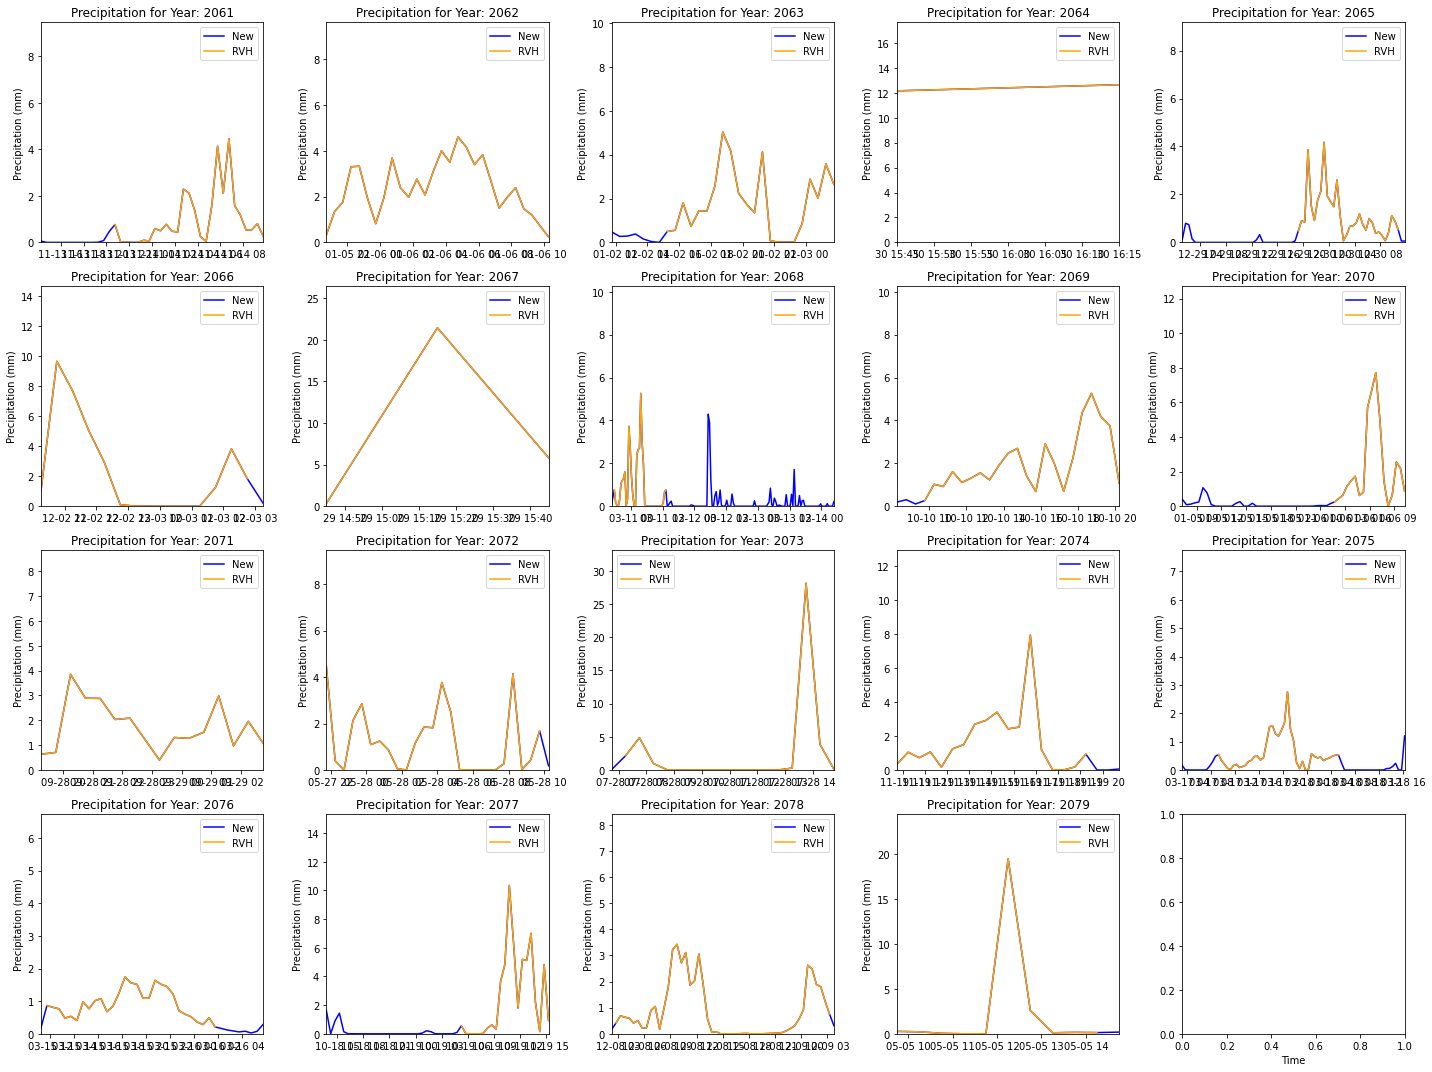

In [9]:
# Set up the figure for subplots in a 4x5 grid
fig, axs = plt.subplots(4, 5, figsize=(20, 15))  # 4 rows, 5 columns
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

# Loop through each year to extract and plot data
for ax_number, year in enumerate(range(2061, 2080)):
    filtered_cube = full_timeslice_cube.extract(iris.Constraint(year=year))
    
    # Extract precipitation data and time coordinates
    precip_data = filtered_cube.data
    time_coord = filtered_cube.coord('time')

    ############## MY METHOD ##############
    my_events = my_find_independent_events(precip_data, time_coord, Tb0)
    # Find the top 1 event for duration of 6 hours
    top_1_6h_events = find_top_n_events_for_duration(my_events, n_events=1, duration_in_hrs=6)
    event = top_1_6h_events[0]
    try:
        event_times = convert_timeformat_array(time_coord[0], event[2].points)
    except:
        event_times = convert_timeformat_array(time_coord[0], event[2])
    event_df = pd.DataFrame({'precipitation (mm)': event[1], 'timestamp': event_times})
    event_df['timestamp'] = pd.to_datetime(event_df['timestamp'])
    # Remove trailing zeroes
    while event_df['precipitation (mm)'].iloc[-1] < 0.05:
        event_df = event_df.iloc[:-1]

    ############## ROBERTO'S METHOD ##############
    time_period = 'Future'
    indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/EventSet/"
    files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv') and '6hrs' in f]
    files = np.sort(files)
    file_num = yr_lookup[str(year)]
    fp = files[file_num]  # Get the corresponding file
    this_event = read_event(gauge_num, indy_events_fp + fp)
    this_event = remove_leading_and_trailing_zeroes(this_event, 0.1)

    # Plot both events on the corresponding subplot
    axs[ax_number].plot(event_df['timestamp'], event_df['precipitation (mm)'], label=f'New', color='blue')
    axs[ax_number].plot(this_event['timestamp'], this_event['precipitation (mm)'], label='RVH', color='orange')
    axs[ax_number].set_title(f'Precipitation for Year: {year}')
    axs[ax_number].set_ylabel('Precipitation (mm)')
    axs[ax_number].legend()

    # Seax_numbernt x and y limits (if needed)
    axs[ax_number].set_xlim([event_df['timestamp'].min(), event_df['timestamp'].max()])
    axs[ax_number].set_ylim([0, event_df['precipitation (mm)'].max() + 5])  # Adjust y-limits as needed

# Set the common x-label for the entire figure
axs[-1].set_xlabel('Time')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
# # Set up the figure for subplots in a 4x5 grid
# fig, axs = plt.subplots(4, 5, figsize=(20, 15))  # 4 rows, 5 columns
# axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

# # Loop through each year to extract and plot data
# for ax_number, year in enumerate(range(2061, 2080)):
#     # print(year, ax_number)
#     filtered_cube = full_timeslice_cube.extract(iris.Constraint(year=year))
    
#     # Extract precipitation data and time coordinates
#     precip_data = filtered_cube.data
#     time_coord = filtered_cube.coord('time')

#     ######################
#     # New method
#     ######################
#     my_events = my_find_independent_events(precip_data, time_coord, Tb0)
#     top_1_6h_events = find_top_n_events_for_duration(my_events, n_events=1, duration_in_hrs=6)
#     event = top_1_6h_events[0]
#     event_df = pd.DataFrame({'precipitation (mm)': event[1]})

#     # Remove trailing zeroes
#     while event_df['precipitation (mm)'].iloc[-1] < 0.05:
#         event_df = event_df.iloc[:-1]

#     ######################
#     # RVH method
#     ######################
#     time_period = 'Future'
#     indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/EventSet/"
#     files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv') and '6hrs' in f]
#     files = np.sort(files)
#     file_num = yr_lookup[str(year)]
#     fp = files[file_num]  # Get the corresponding file
#     this_event = read_event(gauge_num, indy_events_fp + fp)
#     this_event = remove_leading_and_trailing_zeroes(this_event, 0.1)

#     # Plot both events on the corresponding subplot
#     axs[ax_number].plot(event_df['precipitation (mm)'], label=f'RVH', color='blue')
#     axs[ax_number].plot(this_event['precipitation (mm)'], label='Independent Event', color='orange')
#     axs[ax_number].set_title(year)
    
# # Set the common x-label for the entire figure
# axs[-1].set_xlabel('Time')

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the plot
# plt.show()